In [232]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    'Num cells x0.125': load_data('../stats/fpm_4_simplices_x0.5.json'),
    'Num cells x1': load_data('../stats/fpm_4_simplices_x1.json'),
# #     # 'num cells x64': load_data('../stats/fpm_3_x4.json'),
    # 'Num cells x8': load_data('../stats/fpm_4_x2.json'),
# #     # 'num cells x125': load_data('../stats/fpm_3_x5.json'),
    # 'Num cells x27': load_data('../stats/fpm_4_x3.json'),
# #     # 'num cells x216': load_data('../stats/fpm_3_x6.json'),
}

In [233]:
shape = [2, 1]
figsize = (7, 4)

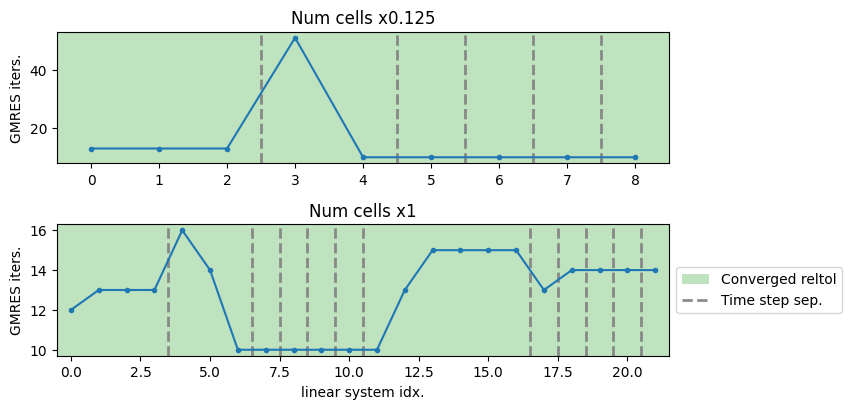

In [234]:
def render_element(entry: Sequence[TimeStepStats]):
    color_converged_reason(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.')

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

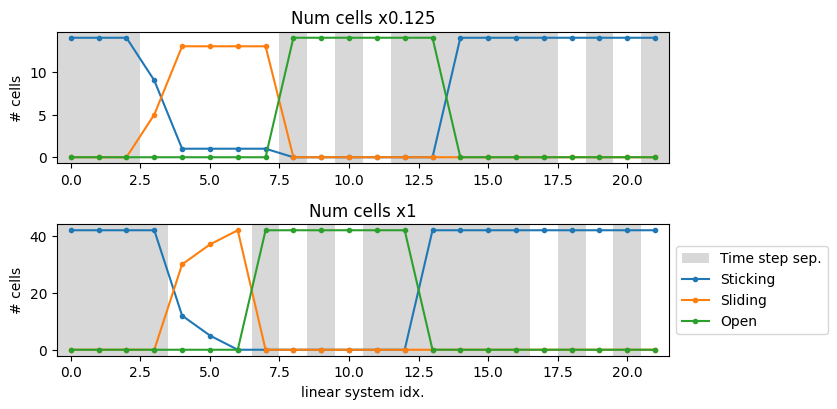

In [55]:
def render_element(entry: Sequence[TimeStepStats]):
    sticking, sliding, open_ = get_num_sticking_sliding_open(entry)
    color_time_steps(entry, fill=True, grid=False, legend=True)
    plt.plot(sticking, label='Sticking', marker='.')
    plt.plot(sliding, label='Sliding', marker='.')
    plt.plot(open_, label='Open', marker='.')

plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel='# cells')

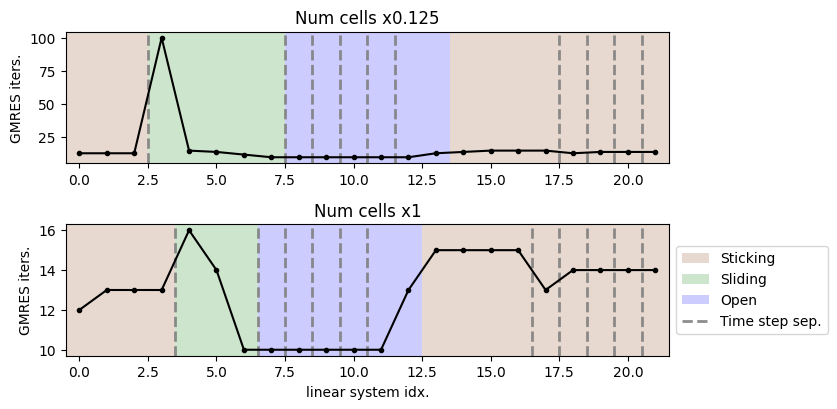

In [56]:
def render_element(entry: Sequence[TimeStepStats]):
    color_sticking_sliding_open(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.', color='black')
    # plt.ylim(top=21)

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

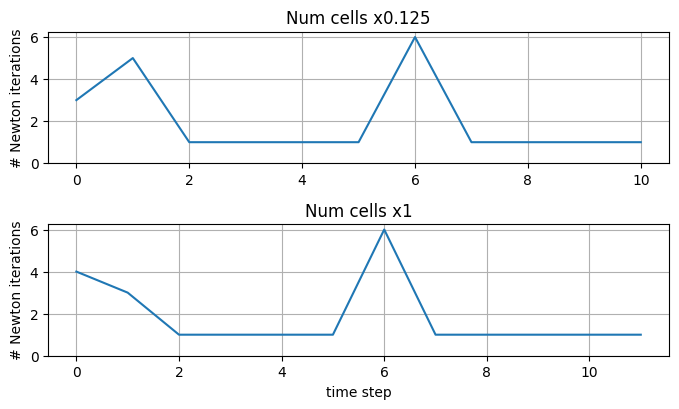

In [57]:
def render_element(entry: Sequence[TimeStepStats]):
    plt.plot(get_newton_iterations(entry))
    plt.ylim(bottom=0)
    plt.grid()

plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel='# Newton iterations', xlabel='time step', legend=False)

# Testing bad matrix

In [101]:
from fpm_4_simplices import make_model

model = make_model()
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()



num sticking: 14
num sliding: 0
num open: 0


In [222]:
mat_idx = 2
entry = data['Num cells x0.125']
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

13


Solve  took: 0.18
True residual decrease: 7.928793765039433e-08


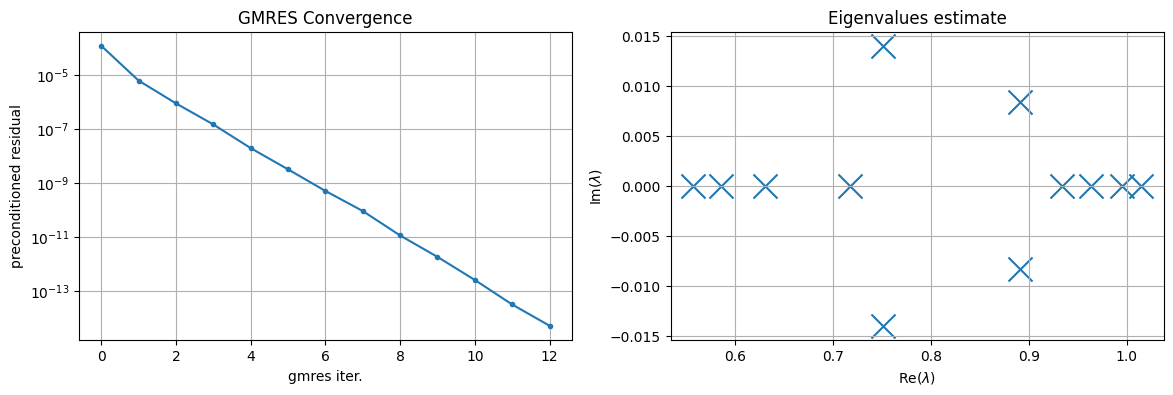

In [223]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(state, iterate_index=0)
perm_mat, prec_orig = model._prepare_solver()
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

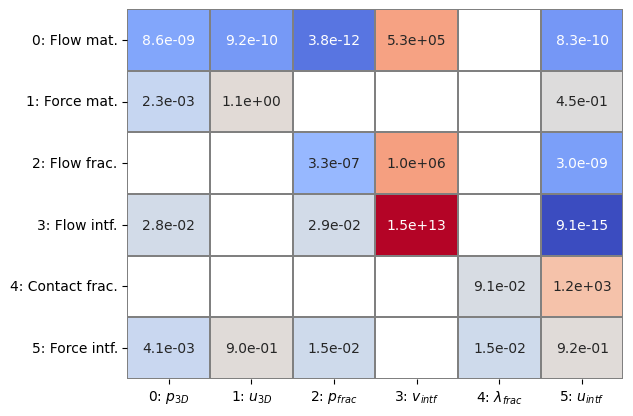

In [225]:
J = perm_mat[:]
J.plot_max()

In [231]:
from block_matrix import SolveSchema, make_solver
from mat_utils import *
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import make_fs

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: make_J44_inv_bdiag(model, bmat=bmat),
    complement=SolveSchema(
        groups=[3],
        solve=lambda bmat: PetscILU(bmat[[3]].mat),
        invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
            # invertor=lambda bmat: make_fs(model, bmat).mat,
            invertor=lambda bmat: model._fixed_stress.mat,
            invertor_type="physical",
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            ),
        ),
    ),
)

bmat_reordered, preconditioner = make_solver(schema=schema, mat_orig=J)
solve_petsc(bmat_reordered.mat, preconditioner, rhs=bmat_reordered.local_rhs(rhs))

LinAlgError: Matrix is singular to machine precision.

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


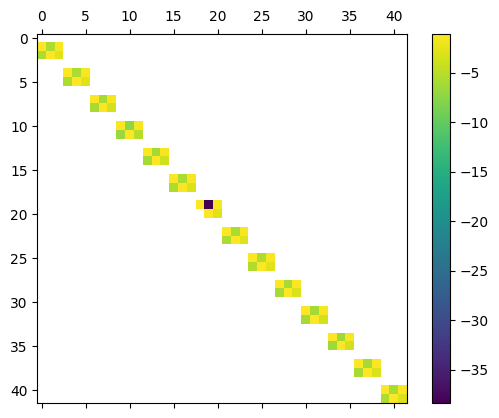

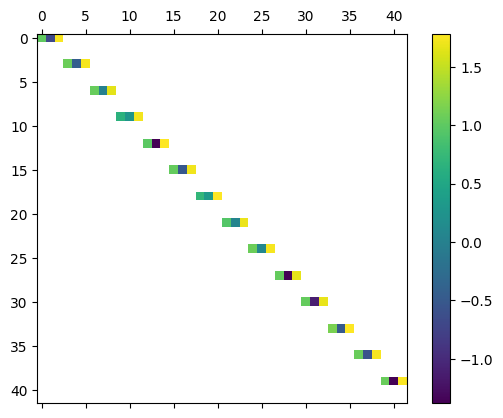

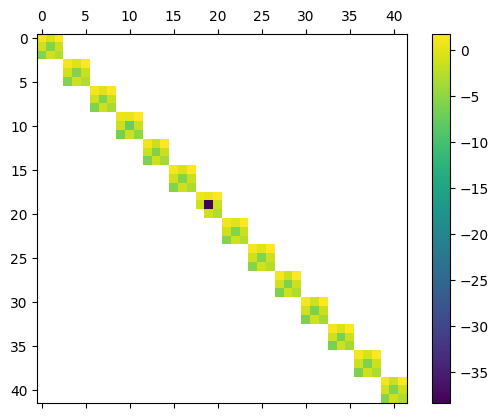

In [229]:
bmat = J
J44 = bmat[4,4].mat
stab = bmat[4, 5].mat @ inv_block_diag(bmat[5, 5].mat, nd=model.nd) @ bmat[5, 4].mat
rowsum = np.array(J44.sum(axis=1)).ravel()
nonzeros = rowsum != 0
stab[nonzeros] = 0
S44 = J44 - stab
plot_mat(J44, log=True)
plot_mat(stab)
plot_mat(S44)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


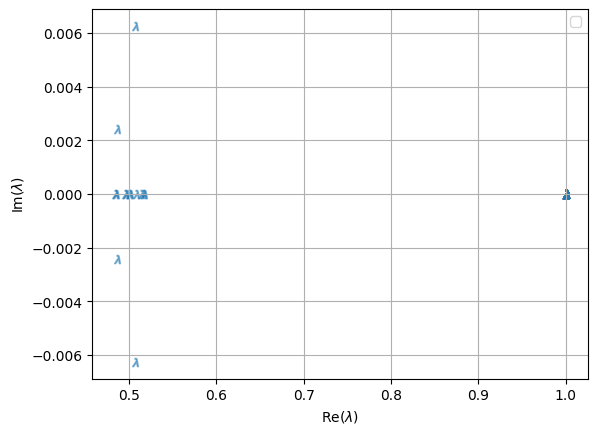

In [230]:
J45 = J[[4,5]].mat
S45 = J[[4,5]]
S45[4, 4] = S44
S45 = S45.mat

plot_eigs(inv(S45) @ J45)